# Prepare Environment

Load necessary modules and attempt to compile the GrOpt library if it isn't already

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import gropt
from helper_utils import *

%matplotlib inline

# GrOpt

### Gradient design toolbox 
#### Written in C (for compiling on scanners), which wrappers in Python and Matlab for prototyping

Ideally **_any_** waveform can be described by a set of constraints on moments and everything else

Currently implemented in various forms on Siemens and GE scanners

***

## Example 1: Phase Encoding Gradient

#### Constraints on:
- Maximum gradient amplitude
- Maximum slew rate
- 0th moment = 11.74 (mT*ms)/m = The area needed to encode a 1mm spatial resolution line in k-space

Min TE = 0.6640625000000001 ms


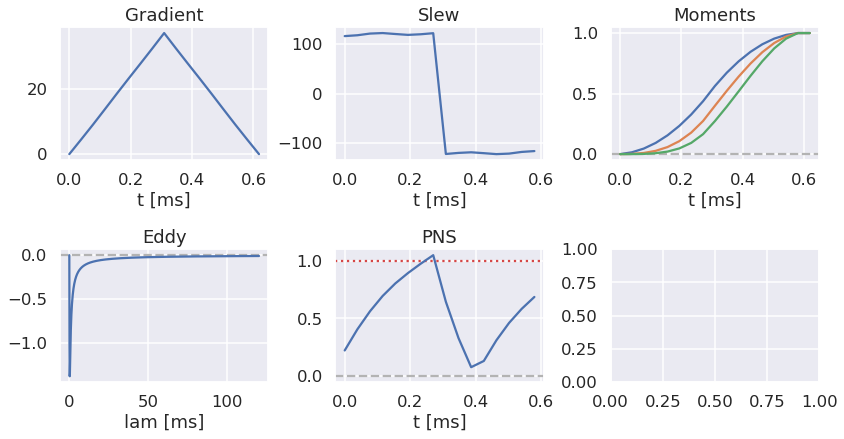

In [2]:
params = {}

# Free mode says we are in a feasibility search, i.e. no objective function
params['mode'] = 'free'

# Set hardware limits
params['gmax']  = 0.05   # Maximum gradient amplitude, G/cm
params['smax']  = 120.0  # Maximum slew rate, mT/m/ms 

# Moment parameters have a lot of options, reading the docs is necessary
params['moment_params']  = [[0, 0, 0, -1, -1, 11.75, 1.0e-3]]

# Raster time of the gradient waveform being optimized
params['dt']  = 40e-6


G, T_min = get_min_TE(params, max_TE = 2)
print('Min TE =', T_min, 'ms')
plot_waveform(G, params)

#### Reducing gmax to see its effect:

Min TE = 0.7716796875 ms


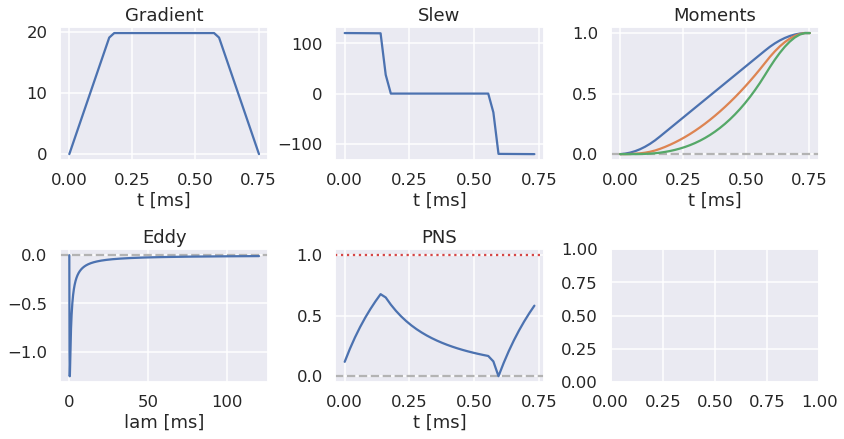

In [3]:
params = {}
params['mode'] = 'free'

# ************
# gmax changed to 20 mT/m 
# ************
params['gmax']  = 0.02
params['smax']  = 120.0

params['moment_params']  = [[0, 0, 0, -1, -1, 11.75, 1.0e-3]]
params['dt']  = 20e-6


G, T_min = get_min_TE(params, max_TE = 2)
print('Min TE =', T_min, 'ms')
plot_waveform(G, params)

#### Adding flow comensation:

Add a constraint on M1 to be 0

Min TE = 1.4312500000000001 ms


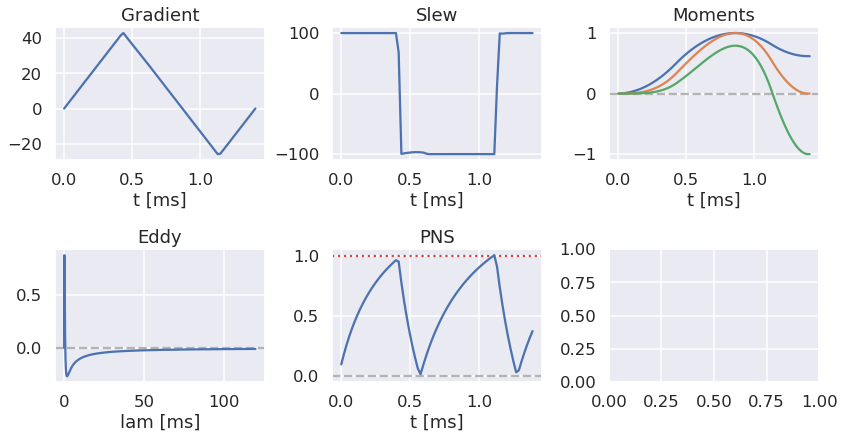

In [4]:
params = {}
params['mode'] = 'free'

params['gmax']  = 0.05
params['smax']  = 100.0

params['moment_params']  = [[0, 0, 0, -1, -1, 11.75, 1.0e-3]]
# ************
# Additional moment constraint added on M1 = 0
# ************
params['moment_params'].append([0, 1, 0, -1, -1, 0, 1.0e-3])
params['dt']  = 20e-6


G, T_min = get_min_TE(params, max_TE = 2.5)
print('Min TE =', T_min, 'ms')
plot_waveform(G, params)

Add M2 as well:

Min TE = 2.3705078125 ms


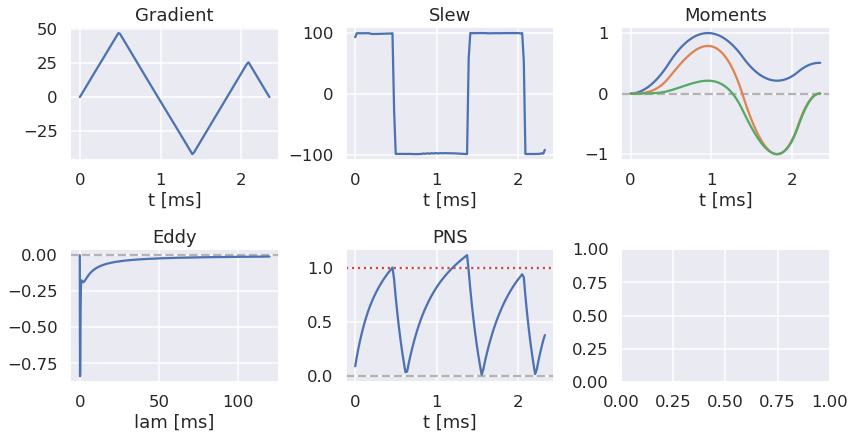

In [7]:
params = {}
params['mode'] = 'free'

params['gmax']  = 0.05
params['smax']  = 100.0

params['moment_params']  = [[0, 0, 0, -1, -1, 11.75, 1.0e-3]]
params['moment_params'].append([0, 1, 0, -1, -1, 0, 1.0e-3])
# ************
# Additional moment constraint added on M2 = 0
# ************
params['moment_params'].append([0, 2, 0, -1, -1, 0, 1.0e-3])
params['dt']  = 20e-6


G, T_min = get_min_TE(params, max_TE = 2.6)
print('Min TE =', T_min, 'ms')
plot_waveform(G, params)

### PNS control

If we use the full power of the gradient slew rates, the same gradient can be played much faster, but the PNS limit will be broken

Min TE = 1.730859375 ms


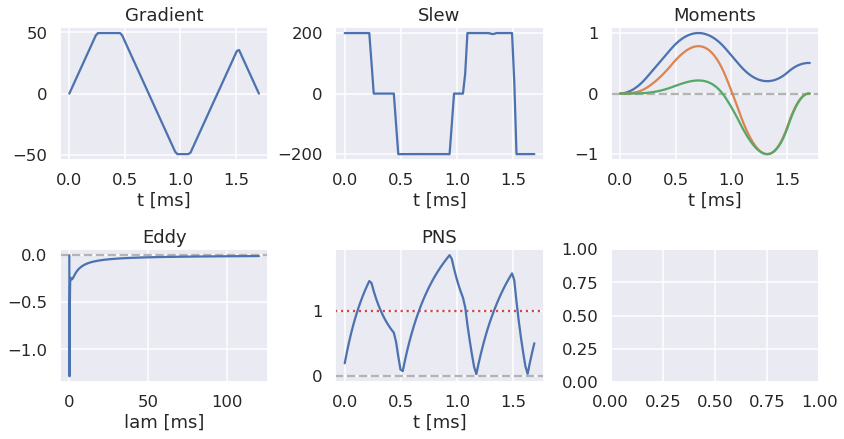

In [10]:
params = {}
params['mode'] = 'free'

params['gmax']  = 0.05
# ************
# Increases slew rate to 200
# ************
params['smax']  = 200.0

params['moment_params']  = [[0, 0, 0, -1, -1, 11.75, 1.0e-3]]
params['moment_params'].append([0, 1, 0, -1, -1, 0, 1.0e-3])
params['moment_params'].append([0, 2, 0, -1, -1, 0, 1.0e-3])
params['dt']  = 20e-6


G, T_min = get_min_TE(params, max_TE = 2.6)
print('Min TE =', T_min, 'ms')
plot_waveform(G, params)

We then keep the slew rates high, but add a PNS constraint to keep PNS < 1.0

Min TE = 1.984375 ms


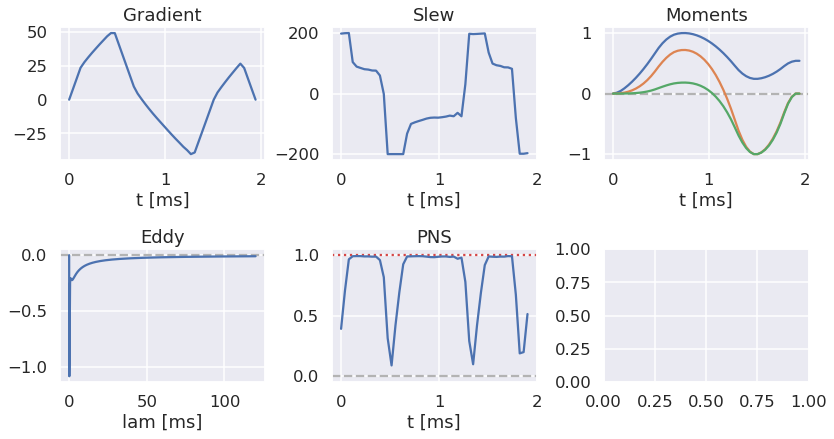

In [17]:
params = {}
params['mode'] = 'free'

params['gmax']  = 0.05
params['smax']  = 200.0

params['moment_params']  = [[0, 0, 0, -1, -1, 11.75, 1.0e-3]]
params['moment_params'].append([0, 1, 0, -1, -1, 0, 1.0e-3])
params['moment_params'].append([0, 2, 0, -1, -1, 0, 1.0e-3])
# ************
# Increase dt a little becasuse PNS is more computationally complex
# ************
params['dt']  = 40e-6

# ************
# Add PNS contraint
# ************
params['pns_thresh'] = 1.0

G, T_min = get_min_TE(params, min_TE = 1.6, max_TE = 2.2)
print('Min TE =', T_min, 'ms')
plot_waveform(G, params)

## Example 2: Diffusion Encoding Gradient

#### Constraints on:
- Maximum gradient amplitude
- Maximum slew rate
- 0th moment = 0 (mT*ms)/m 
- Add objective function to maximize b-value
- Add G=0 for the excitation and 180
- Add compensation to assume that there is some time between the end of the encoding waveform and the TE


Min TE = 63.90625 ms


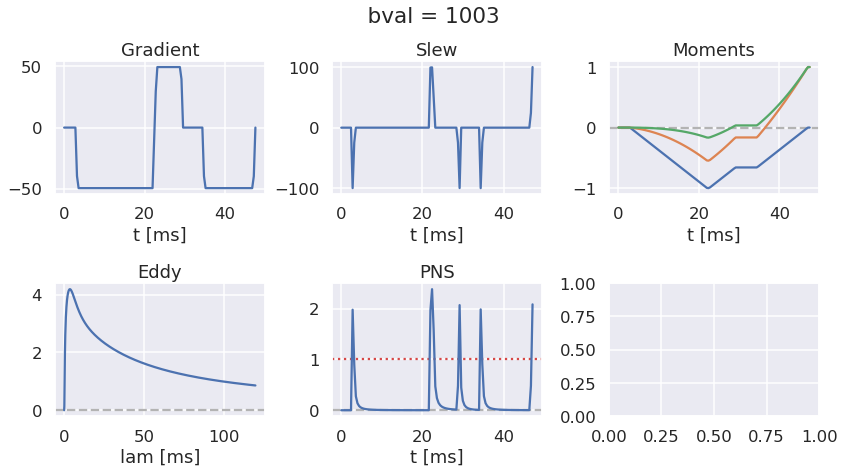

In [21]:
params = {}
# ************
# Objective function now maximized b-value, also allows some shorthand for rf, moment nulling, and readout TE
# ************
params['mode'] = 'diff_bval'
# ************
# Short hand for moment nulling of M0
# ************
params['MMT']  = 0

params['gmax']  = 0.05
params['smax']  = 100.0

# ************
# Constraints define rf gradient dead times, and the time to TE after this waveform
# ************
params['T_readout']  = 16.0
params['T_90']  = 3
params['T_180']  = 5

# ************
# Waveforms are much longer, but we can also get away with much higher dt to keep compute times fast
# ************
params['dt']  = 400e-6

# ************
# b-value = 1000 is selected here
# ************
G_min, T_min = get_min_TE(params, bval = 1000, min_TE = 40, max_TE = 120)
print('Min TE =', T_min, 'ms')
plot_waveform(G_min, params)

Min TE = 106.5625 ms


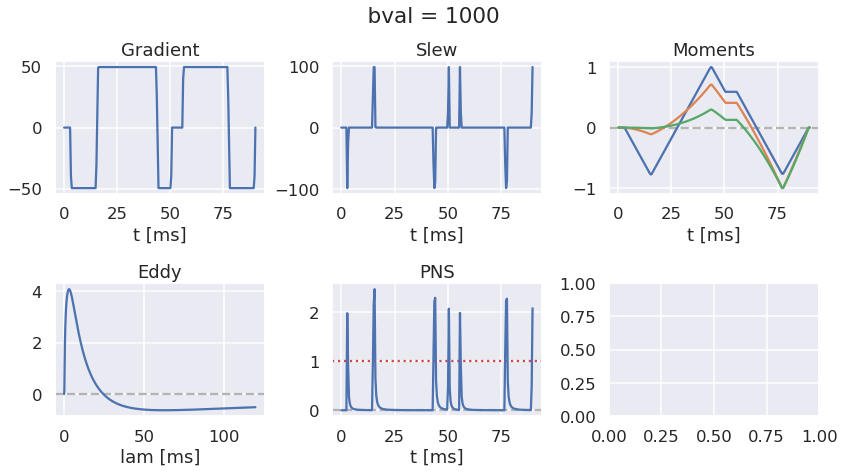

In [23]:
params = {}
params['mode'] = 'diff_bval'
# ************
# M0 M1 and M2 nulling
# ************
params['MMT']  = 2

params['gmax']  = 0.05
params['smax']  = 100.0


params['T_readout']  = 16.0
params['T_90']  = 3
params['T_180']  = 5


params['dt']  = 400e-6


G_min, T_min = get_min_TE(params, bval = 1000, min_TE = 80, max_TE = 120)
print('Min TE =', T_min, 'ms')
plot_waveform(G_min, params)

We can also constrain PNS

Min TE = 107.890625 ms


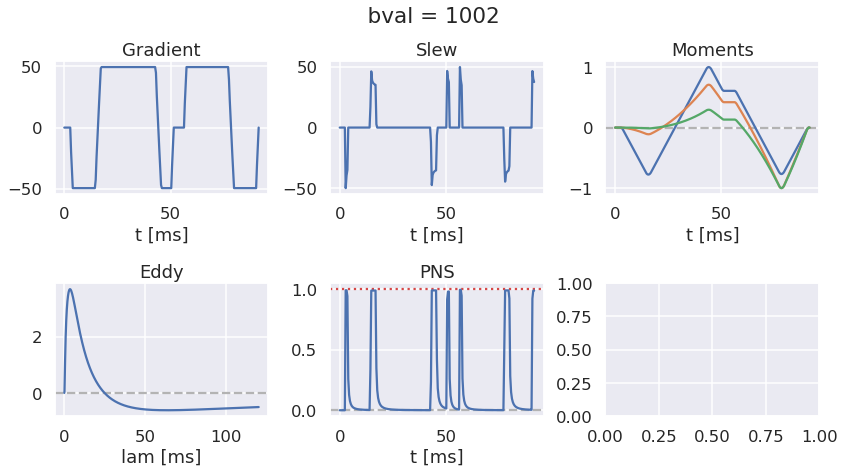

In [24]:
params = {}
params['mode'] = 'diff_bval'
# ************
# M0 M1 and M2 nulling
# ************
params['MMT']  = 2

params['gmax']  = 0.05
params['smax']  = 100.0


params['T_readout']  = 16.0
params['T_90']  = 3
params['T_180']  = 5


params['dt']  = 400e-6
params['pns_thresh']  = 1.0

G_min, T_min = get_min_TE(params, bval = 1000, min_TE = 80, max_TE = 120)
print('Min TE =', T_min, 'ms')
plot_waveform(G_min, params)

Back to only M0 nulling, but now we will also null an eddy current time constant (lmabda = 60 ms)

Min TE = 85.859375 ms


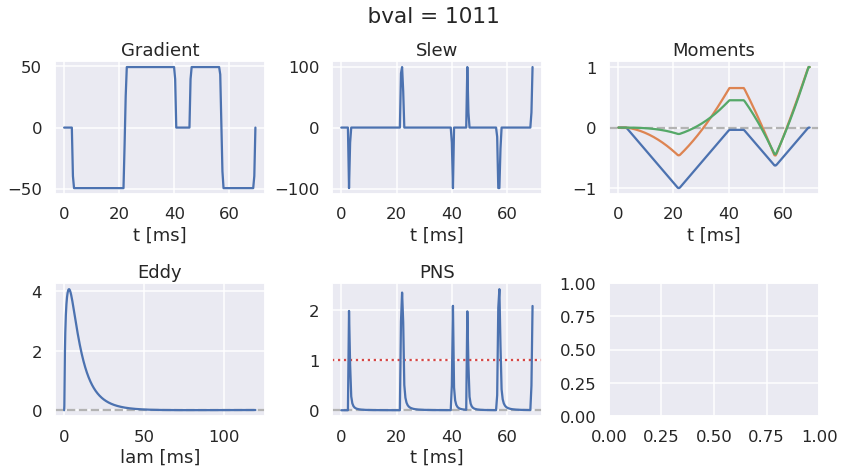

In [25]:
params = {}
params['mode'] = 'diff_bval'
# ************
# M0 nulling
# ************
params['MMT']  = 0

params['gmax']  = 0.05
params['smax']  = 100.0


params['T_readout']  = 16.0
params['T_90']  = 3
params['T_180']  = 5



params['dt']  = 400e-6

# ************
# Null eddy current for lambda = 60ms
# ************
params['eddy_params']  = [[60.0, 0.0, 1.0e-4, 0.0]]

G_min, T_min = get_min_TE(params, bval = 1000, min_TE = 80, max_TE = 120)
print('Min TE =', T_min, 'ms')
plot_waveform(G_min, params)